In [1]:
from dataloader import fashion_mnist, cifar10, cifar100, imagenet
from model.pytorch_pretrained_vit import ViT

from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel
from PIL import Image
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch.nn as nn
import torch.optim as optim

import torchattacks
import torch
from PIL import Image
import requests

In [67]:
from utils import load_data, save_data

In [ ]:
from abc import abstractmethod
import torch
from models import BaseVAE
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple

In [2]:
device = 'cuda:4'

In [3]:
# net = ViT(1000, pretrain_idx=0)
net = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224')

In [70]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs.logits, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        imagefs = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images


def pgd_correction(model, images, labels, eps=.1, alpha=2/255, iters=40):
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs.logits, labels).to(device)
        cost.backward()

        adv_images = images - alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images - eta, min=0, max=1).detach_()
            
    return images

In [5]:
trainset, valset, _ = imagenet(batch_size=4, classes=1000)

Using augmented IMAGENET.


In [6]:
net.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=102

In [77]:
for X, y in trainset:
    if 680 in y:
        break

In [78]:
X = X.to(device)

In [79]:
outputs = net(X)

logits = outputs.logits
class_idx = logits.argmax(dim=1).cpu().detach().numpy()
pred_labels=[net.config.id2label[idx] for idx in class_idx]

In [80]:
adv_x = pgd_attack(net, X, y.to(device))

In [81]:
odin_X = odin_perturb(net, X, y.to(device))

In [88]:
outputs = net(adv_x)

logits = outputs.logits
class_idx = logits.argmax(dim=1).cpu().detach().numpy()
pert_labels=[net.config.id2label[idx] for idx in class_idx]

outputs = net(odin_X)

logits = outputs.logits
class_idx = logits.argmax(dim=1).cpu().detach().numpy()
odin_labels=[net.config.id2label[idx] for idx in class_idx]

In [83]:
true_labels=[net.config.id2label[idx] for idx in y.numpy()]

In [84]:
true_labels

['jeep, landrover',
 'kit fox, Vulpes macrotis',
 'nipple',
 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


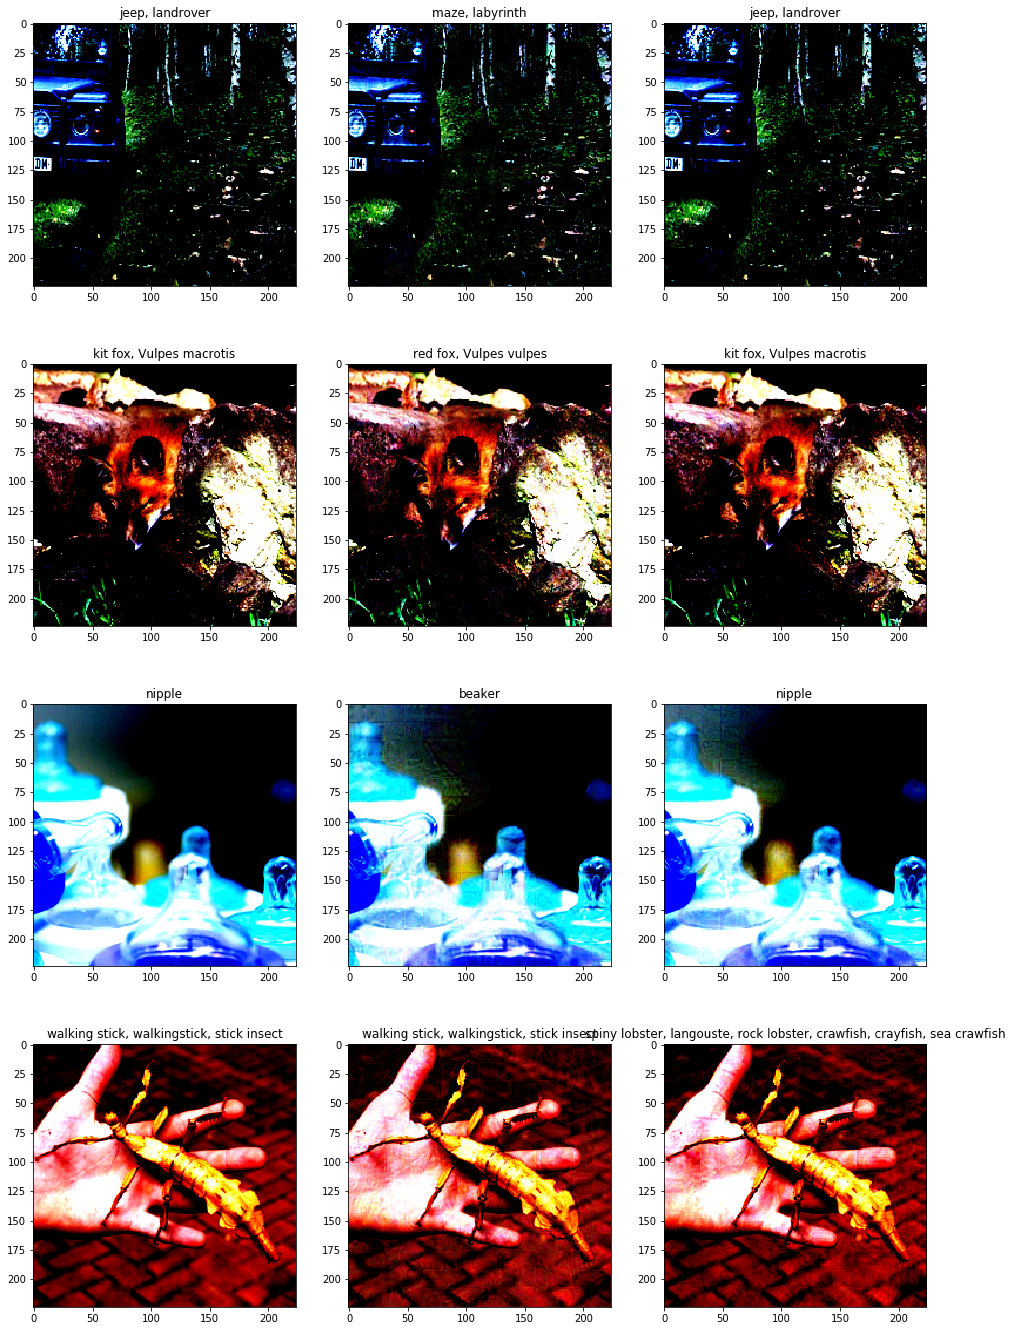

In [89]:
fig, ax = plt.subplots(4,3, figsize=(16,24))
for i in range(4):
    ax[i][0].imshow(X[i].cpu().detach().numpy().transpose((1,2,0)), interpolation='nearest')
    ax[i][0].set_title(pred_labels[i])
    ax[i][1].imshow(adv_x[i].cpu().detach().numpy().transpose((1,2,0)), interpolation='nearest')
    ax[i][1].set_title(pert_labels[i])
    ax[i][2].imshow(odin_X[i].cpu().detach().numpy().transpose((1,2,0)), interpolation='nearest')
    ax[i][2].set_title(odin_labels[i])
plt.show()

In [ ]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [ ]:

# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [9]:
adv = torchattacks.PGDL2(model, eps=8/255, alpha=2/255, steps=4)

In [30]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


In [34]:
label = torch.zeros_like(logits.squeeze())
label[predicted_class_idx] = 1

In [37]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [39]:
noise_img = adv(inputs.pixel_values, label)

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not SequenceClassifierOutput

In [ ]:
plt.imshow(X[i].numpy().transpose((1,2,0)), interpolation='nearest')